Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать **подбор гиперпараметров** с помощью базовых и продвинутых методов оптимизации.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics

import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

In [2]:
data = pd.read_csv('./_train_sem09.csv')
data.shape #3751x1777
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Предварительная обработка не требуется, данные уже закодированы и нормализованы.

<AxesSubplot:xlabel='Activity', ylabel='count'>

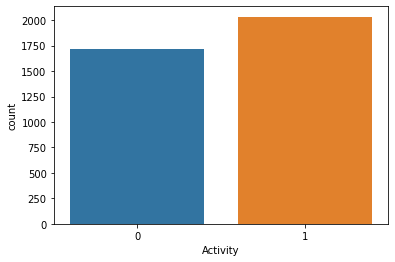

In [3]:
X = data.drop(['Activity'], axis=1) 
y = data['Activity'] #целевая переменная, описывающая фактический биологический ответ

sns.countplot(data=data, x='Activity')

Классы распределены равномерно, не стратифицируем

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

## <center> Логистическая регрессия

In [5]:
log_reg = linear_model.LogisticRegression(max_iter=50)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)

print('f1_score {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score 0.79


C:\Users\grish\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 score: 0.79
Попробуем подобрать гиперпараметры.

**GridSearchCV**

In [6]:
#зададим немного расширенную, но неконфликтную сетку
param_grid = {
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'C': list(np.linspace(0.01, 1, 10, dtype=float))
}

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time 
grid_search.fit(X_train, y_train) 

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

C:\Users\grish\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 4.94 s
Wall time: 29min 29s
Наилучшие значения гиперпараметров: {'C': 0.12, 'penalty': 'l2', 'solver': 'lbfgs'}
f1_score на тестовом наборе: 0.80


f1_score на тестовом наборе: 0.80
Wall time: **29min 29s**
Наилучшие значения гиперпараметров: **solver=lbfgs, penalty=l2, C=0.12**

**RandomizedSearchCV**

In [7]:
param_distributions = {
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'C': list(np.linspace(0.01, 1, 10, dtype=float))
}

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  

%time 
random_search.fit(X_train, y_train) 

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
y_test_pred = random_search.predict(X_test)
print('f1_score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: total: 5.66 s
Wall time: 17min 55s
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}
f1_score: 0.80


C:\Users\grish\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1_score: 0.80
Wall time: **17min 55s**
Наилучшие значения гиперпараметров: **solver=sag, penalty=l2, C=0.12**

**Hyperopt**

In [8]:
# зададим пространство поиска гиперпараметров
space = {
    'penalty': hp.choice('penalty', ['l2', 'none']),
    'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
    'C': hp.quniform('C', 0.01, 1, 0.01)
}

# функция получает комбинацию гиперпараметров в params
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):  
    
    params = {
    'penalty': params['penalty'],
    'solver': params['solver'],
    'C': params['C']
    }
    
    model = linear_model.LogisticRegression(**params, max_iter=50, random_state=42)
    cv_metrics = cross_validate(model, X, y, cv=5, scoring="f1", n_jobs=-1)
    score = np.mean(cv_metrics['test_score'])
    return -score

# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_rf, # наша функция
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=50, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(42) # фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров {}'.format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|███████████████████████████████████████████████| 50/50 [09:20<00:00, 11.21s/trial, best loss: -0.7863639080513779]
Наилучшие значения гиперпараметров {'C': 0.04, 'penalty': 0, 'solver': 0}


Наилучшие значения гиперпараметров: **solver=lbfgs, penalty=l2, C=0.04**

**Optuna**

In [9]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    C = trial.suggest_float('C', 0.01, 1)
    
  # создаем модель
    model = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=50,
        random_state=42
    )
    
    score = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

%time
# cоздаем объект исследования
study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-01-20 18:59:55,078] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-01-20 19:00:07,005] Trial 0 finished with value: 0.7794234163503949 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.17538545688514603}. Best is trial 0 with value: 0.7794234163503949.
[I 2023-01-20 19:00:09,703] Trial 1 finished with value: 0.7626835828208308 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.5174147428816419}. Best is trial 0 with value: 0.7794234163503949.
[I 2023-01-20 19:00:18,199] Trial 2 finished with value: 0.7721582771625701 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.20136684304644703}. Best is trial 0 with value: 0.7794234163503949.
[I 2023-01-20 19:00:26,482] Trial 3 finished with value: 0.7736894885325222 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.8398637755219975}. Best is trial 0 with value: 0.7794234163503949.
[I 2023-01-20 19:00:29,410] Trial 4 finished with value: 0.7763421841396861 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.6757123888487144}. Best is trial 0 with value:

[I 2023-01-20 19:09:53,139] Trial 38 finished with value: 0.7626835828208308 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.27243808701695754}. Best is trial 37 with value: 0.7857014695485535.
[I 2023-01-20 19:10:09,330] Trial 39 finished with value: 0.7748304049445134 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 0.4675999307691644}. Best is trial 37 with value: 0.7857014695485535.
[I 2023-01-20 19:10:18,069] Trial 40 finished with value: 0.7721582771625701 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.6709665575923544}. Best is trial 37 with value: 0.7857014695485535.
[I 2023-01-20 19:10:28,961] Trial 41 finished with value: 0.7842721465322325 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.06212972673757164}. Best is trial 37 with value: 0.7857014695485535.
[I 2023-01-20 19:10:39,903] Trial 42 finished with value: 0.785097902148751 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.07517129640217056}. Best is trial 37 w

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.07296757489909039}


Наилучшие значения гиперпараметров: **solver=saga, penalty=l2, C=0.07296757489909039**

## <center> Случайный лес

**Random Forest** (n_estimators = количество деревьев, 100 штук;
                   max_depth = максимальная глубина дерева, большая;
                   max_features = максимальное количество признаков, учитываемых при разделении;
                   subsample = доля выборки, которая используется для обучения каждого дерева)

In [10]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.83


**GridSearchCV**

In [12]:
param_grid = {
    'n_estimators': list(np.linspace(50, 200, 4, dtype=int)),
    'min_samples_leaf': list(np.linspace(5, 20, 4, dtype=int)),
    'max_depth': list(np.linspace(10, 25, 4, dtype=int)),
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

%time 
grid_rf.fit(X_train, y_train)

y_train_pred = grid_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_rf.best_params_))

f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.84
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 200}


Наилучшие значения гиперпараметров:**n_estimators=200, min_samples_leaf=5, max_depth=15, criterion=entropy**

**RandomizedSearchCV**

In [13]:
param_distributions = {
    'n_estimators': list(np.linspace(50, 200, 4, dtype=int)),
    'min_samples_leaf': list(np.linspace(5, 20, 4, dtype=int)),
    'max_depth': list(np.linspace(10, 25, 4, dtype=int)),
    'criterion': ['gini', 'entropy', 'log_loss']
}

random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50,
    n_jobs = -1
)  

%time 
random_search_rf.fit(X_train, y_train) 

y_train_pred = random_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_rf.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 150, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'entropy'}


Наилучшие значения гиперпараметров:**n_estimators=150, min_samples_leaf=5, max_depth=15, criterion=entropy**

**Hyperopt**

In [14]:
# зададим пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 20, 1),
    'max_depth': hp.quniform('max_depth', 10, 25, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss'])
}

# функция получает комбинацию гиперпараметров в params
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):  
    params = {
    'n_estimators': int(params['n_estimators']),
    'max_depth': int(params['max_depth']), 
    'min_samples_leaf': int(params['min_samples_leaf']),
    'criterion': params['criterion']
    }
    
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    cv_metrics = cross_validate(model, X, y, cv=5, scoring="f1", n_jobs=-1)
    score = np.mean(cv_metrics['test_score'])
    return -score

# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_rf, # наша функция
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=50, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров {}'.format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|███████████████████████████████████████████████| 50/50 [05:00<00:00,  6.01s/trial, best loss: -0.8074989808851509]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 16.0, 'min_samples_leaf': 5.0, 'n_estimators': 187.0}


Наилучшие значения гиперпараметров:**n_estimators=187.0, min_samples_leaf=5.0, max_depth=16.0, criterion=entropy**

**Optuna**

In [15]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 200, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 20, 1)
    max_depth = trial.suggest_int('max_depth', 10, 25, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    
  # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )
    
    score = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

%time
# cоздаем объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

print('Наилучшие значения гиперпараметров {}'.format(study.best_params))

[I 2023-01-20 19:37:51,399] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-01-20 19:37:56,605] Trial 0 finished with value: 0.7759068345431082 and parameters: {'n_estimators': 147, 'min_samples_leaf': 20, 'max_depth': 22, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7759068345431082.
[I 2023-01-20 19:38:02,888] Trial 1 finished with value: 0.7915342086361388 and parameters: {'n_estimators': 152, 'min_samples_leaf': 10, 'max_depth': 13, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.7915342086361388.
[I 2023-01-20 19:38:05,539] Trial 2 finished with value: 0.790070100444564 and parameters: {'n_estimators': 51, 'min_samples_leaf': 9, 'max_depth': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7915342086361388.
[I 2023-01-20 19:38:12,259] Trial 3 finished with value: 0.7921510997345205 and parameters: {'n_estimators': 189, 'min_samples_leaf': 10, 'max_depth': 16, 'criterion': 'gini'}. Best is trial 3 with value: 0.7921510997345205.
[I 2023-01-20 19:38:20,884] Trial 4 finished with value: 0.797672990700691 and parameters: {

[I 2023-01-20 19:40:53,429] Trial 35 finished with value: 0.7949709794544221 and parameters: {'n_estimators': 94, 'min_samples_leaf': 6, 'max_depth': 21, 'criterion': 'gini'}. Best is trial 31 with value: 0.802883869131171.
[I 2023-01-20 19:40:57,611] Trial 36 finished with value: 0.785305288915479 and parameters: {'n_estimators': 87, 'min_samples_leaf': 11, 'max_depth': 22, 'criterion': 'entropy'}. Best is trial 31 with value: 0.802883869131171.
[I 2023-01-20 19:41:02,103] Trial 37 finished with value: 0.795489839068489 and parameters: {'n_estimators': 105, 'min_samples_leaf': 8, 'max_depth': 24, 'criterion': 'gini'}. Best is trial 31 with value: 0.802883869131171.
[I 2023-01-20 19:41:08,103] Trial 38 finished with value: 0.7978165410713695 and parameters: {'n_estimators': 112, 'min_samples_leaf': 6, 'max_depth': 25, 'criterion': 'log_loss'}. Best is trial 31 with value: 0.802883869131171.
[I 2023-01-20 19:41:11,280] Trial 39 finished with value: 0.797711181842063 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 99, 'min_samples_leaf': 5, 'max_depth': 24, 'criterion': 'gini'}


Наилучшие значения гиперпараметров:**n_estimators=99, min_samples_leaf=5, max_depth=24, criterion=gini*